## INTRO & SETTINGS

The goal of this tutorial is to show the capabilities of `LF2I` and its usage with a simple example: inferring the 2-dimensional mean of a Gaussian distribution with fixed covariance.

In this case we will use the `Waldo` test statistic (see https://arxiv.org/abs/2205.15680)

In [2]:
import torch

PARAM_DIM = 2
DATA_DIM = 2
DATA_SAMPLE_SIZE = 1  # assume we get to see only one observed sample for each “true” parameter
CONFIDENCE_LEVEL = 0.9

## SIMULATE

Let's start from the simulator, which is used internally to generate the data needed to 
1. estimate the test statistics;
2. estimate the critical values; and 
3. diagnose the constructed confidence regions 

In [3]:
from lf2i.simulator.gaussian import GaussianMean

In [4]:
simulator = GaussianMean(
    likelihood_cov=0.01,
    prior='uniform',
    parameter_space_bounds={'low': -1, 'high': 1},
    param_grid_size=10_000,
    param_dim=PARAM_DIM, 
    data_dim=DATA_DIM,
    data_sample_size=DATA_SAMPLE_SIZE
)

#### Observation

For simplicity, let's use the simulator to generate one “observed” sample from the likelihood as well

In [5]:
true_param = torch.Tensor([0, 0])
observed_x = simulator.likelihood(true_param).sample(sample_shape=(DATA_SAMPLE_SIZE, ))

true_param.shape, observed_x.shape

(torch.Size([2]), torch.Size([1, 2]))

## CONFIDENCE SET by leveraging a POSTERIOR ESTIMATOR

Assume we want to do inference on the Gaussian mean by estimating its posterior distribution. `Waldo` allows to leverage a neural posterior estimator like `NPE` to obtain a confidence region for the parameter of interest that is guaranteed to have the desired level of coverage regardless of 
1. the prior distribution;
2. the true value of the parameter;
3. the size of the observed sample

The posterior estimator can be already trained or not. The example below assumes the estimator has not been trained yet

In [6]:
from lf2i.inference.lf2i import WALDO
from lf2i.plot.confidence_regions import plot_parameter_region

In [7]:
waldo = WALDO(
    simulator=simulator,
    estimator='snpe',
    method='posterior',
    confidence_level=CONFIDENCE_LEVEL,
    num_posterior_samples=10_000  # used to approximate conditional mean and variance of the Waldo test statistic
)

In [8]:
confidence_region = waldo.infer(x=observed_x, b=10_000, b_prime=5_000)

 Neural network successfully converged after 87 epochs.

Approximating conditional mean and covariance: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


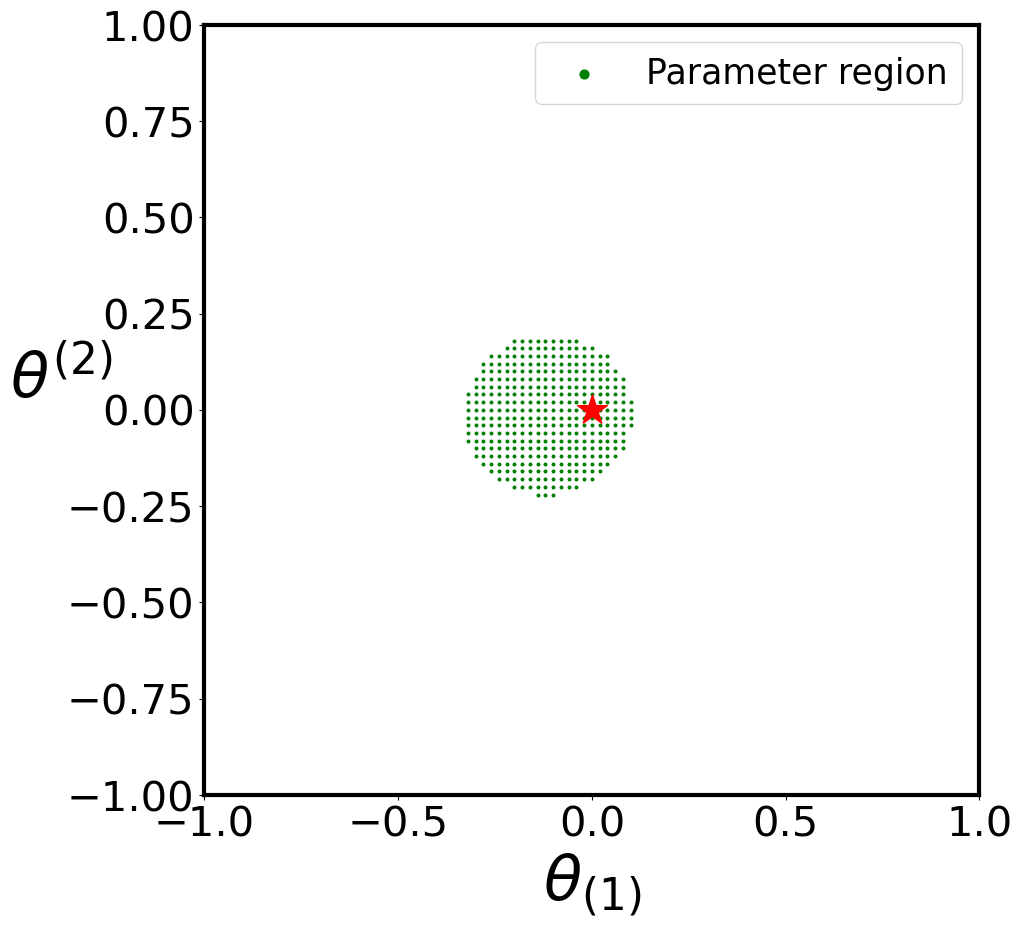

In [9]:
# the star is the true parameter
plot_parameter_region(
    confidence_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(10, 10)
)

Let's try with a different observation

In [22]:
true_param = torch.Tensor([-0.75, -0.5])
observed_x = simulator.likelihood(true_param).sample(sample_shape=(DATA_SAMPLE_SIZE, ))

true_param.shape, observed_x.shape

(torch.Size([2]), torch.Size([1, 2]))

In [23]:
# this run will use the previously estimated posterior (for the test statistics) and crtitical values
confidence_region = waldo.infer(x=observed_x, b=10_000, b_prime=5_000)

Approximating conditional mean and covariance: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]


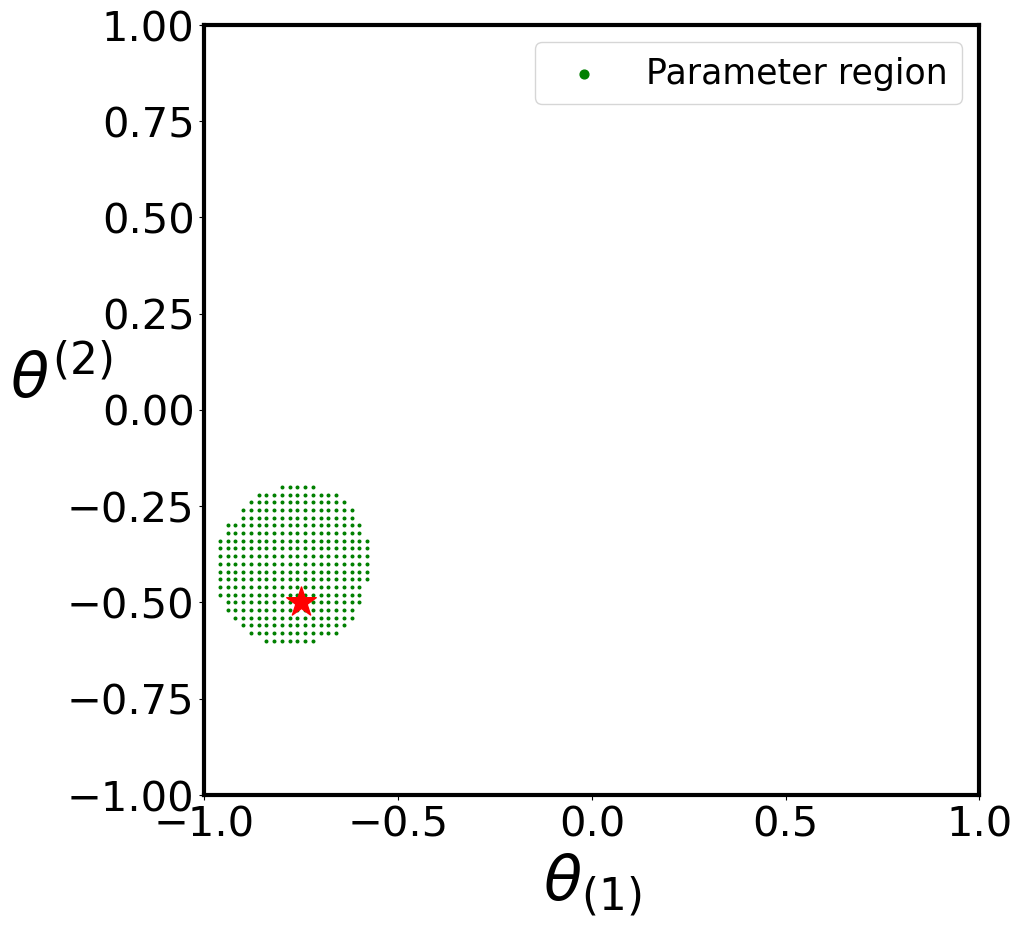

In [24]:
plot_parameter_region(
    confidence_region=confidence_region[0],
    param_dim=PARAM_DIM,
    true_parameter=true_param,
    parameter_space_bounds=simulator.parameter_space_bounds,
    figsize=(10, 10)
)

## DIAGNOSTICS

In [13]:
from lf2i.plot.coverage_diagnostics import coverage_regions_plot

In [17]:
parameters, mean_proba, upper_proba, lower_proba = waldo.diagnose(
    b_doubleprime=10_000,
    region_type='lf2i'
)

Approximating conditional mean and covariance: 100%|██████████| 10000/10000 [07:17<00:00, 22.88it/s]


Coverage probability is approximately 90%, as desired

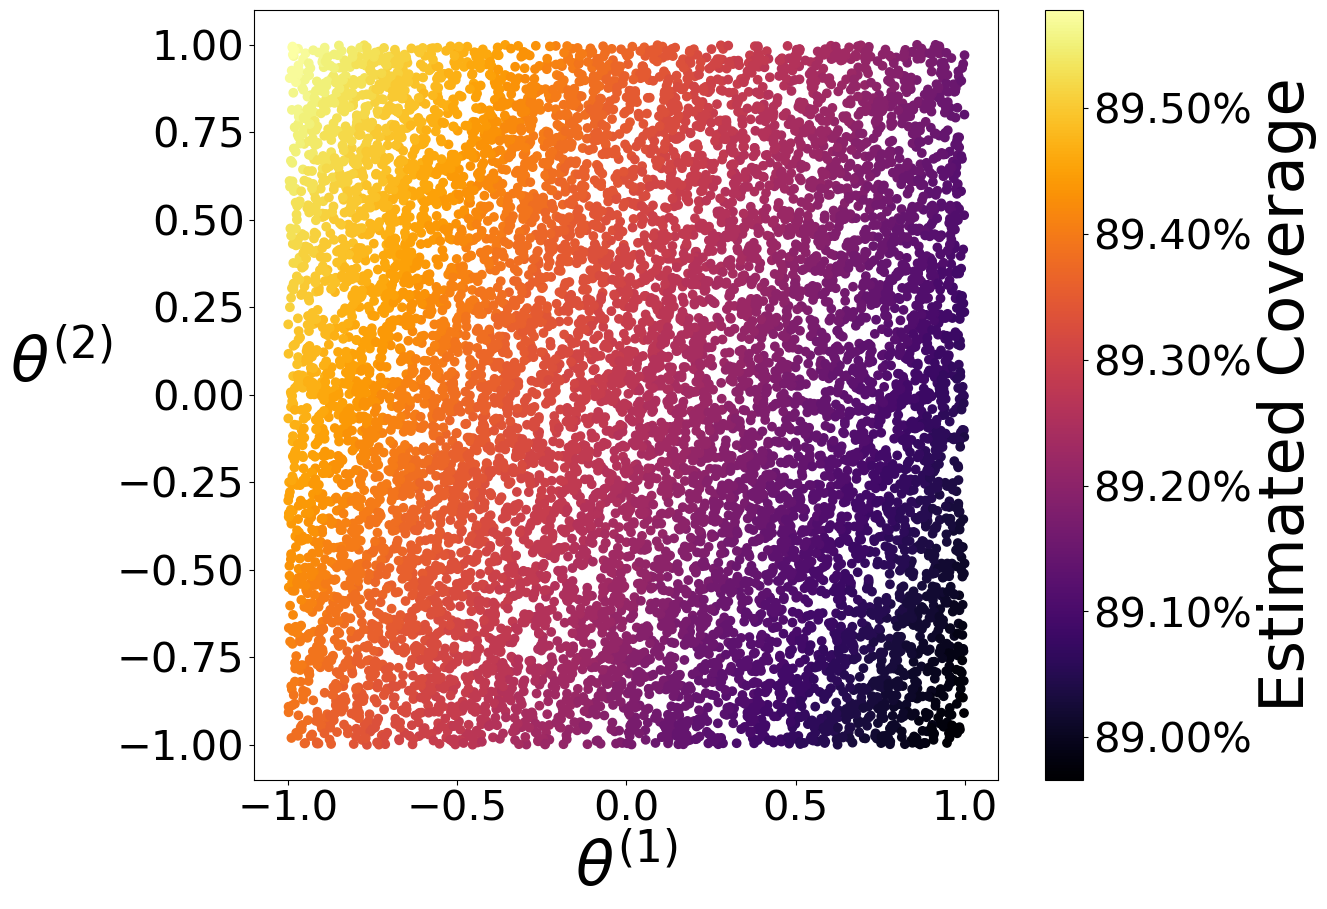

In [21]:
# only plotting mean coverage probability in 2 dimensions
coverage_regions_plot(
    parameters=parameters,
    mean_proba=mean_proba, 
    upper_proba=None,
    lower_proba=None,
    confidence_level=CONFIDENCE_LEVEL,
    param_dim=PARAM_DIM,
    figsize=(12, 10)
)